In [89]:

import torch
from torch.nn import functional as FF
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler
from tqdm import tqdm
import yaml
import wandb
from utils.dataloader_jetnet import PointCloudDataloader
ckptdir="/gpfs/dust/maxwell/user/kaechben/thesis/"
model_name="tnf"#"pf",,"nf","tnf"

ckpt="t_{}low.ckpt".format(model_name)
ckpt=ckptdir+ckpt
print(ckpt)
def load_model(ckpt,model):
    flow_state_dict = {k.replace('flow.', ''): v for k, v in ckpt["state_dict"].items() if 'flow' in k}
    if "adversarial" not in ckpt["hyper_parameters"].keys():
        ckpt["hyper_parameters"]["adversarial"]=False
    flow=model(**ckpt["hyper_parameters"])
    
    flow.flow.load_state_dict(flow_state_dict)
    if config["context_features"]>0 and config["pf"]:
        context_state_dict = {k.replace('shape.', ''): v for k, v in ckpt["state_dict"].items() if 'shape' in k}
        flow.shape.load_state_dict(context_state_dict)
        if config["adversarial"]:
            context_state_dict = {k.replace('dis_net.', ''): v for k, v in ckpt["state_dict"].items() if 'dis_net' in k}
            flow.dis_net.load_state_dict(context_state_dict)
    return flow
state_dict=torch.load(ckpt)
config=state_dict["hyper_parameters"]
config["pf"]=False
if model_name=="ipf" or model_name=="pf" or model_name=="apf":
    config["pf"]=True
    from fit.fit_pnf import PNF as model  
elif model_name=="nf" or model_name=="ccnf" or model_name=="cnf":
    from fit.fit_nf import NF as model
elif model_name=="tnf":
    from fit.fit_tnf import TNF as model 

    
model=load_model(state_dict,model)

    

/gpfs/dust/maxwell/user/kaechben/thesis/t_tnflow.ckpt


/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_jetnet/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [90]:


import pytorch_lightning as pl
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.weight_norm as weight_norm
from torch.nn import Parameter

data_module = PointCloudDataloader(**config)
data_module.setup("fit")
model.bins=[100,100,100]
model.n_dim = 3
model.scaler=data_module.scaler
model.w1m_best=0.01
model.min_pt=data_module.min_pt
model.max_pt=data_module.max_pt
mins=torch.ones(config["n_dim"]).unsqueeze(0)
maxs=torch.ones(config["n_dim"]).unsqueeze(0)
n=[]
for i in data_module.train_dataloader():
    mins=torch.min(torch.cat((mins,i[0][~i[1]].min(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    maxs=torch.max(torch.cat((maxs,i[0][~i[1]].max(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    n.append((~i[1]).sum(1))
model.maxs=maxs.cuda()
model.mins=mins.cuda()
model.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.swa=False
model.scaler=model.scaler.to("cuda")
model.scaler.std=model.scaler.std.cuda()
model.scaled_mins=torch.tensor(data_module.mins).cuda()
model.scaled_maxs=torch.tensor(data_module.maxs).cuda()
# model.on_validation_epoch_start=on_validation_epoch_start
trainer = pl.Trainer(
        devices=1,
        accelerator="gpu",
    )
trainer.validate(model, dataloaders=data_module.test_dataloader())

tensor([0.1158, 0.1166, 0.0394])


/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_jetnet/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]sample lengths: 50000 50000


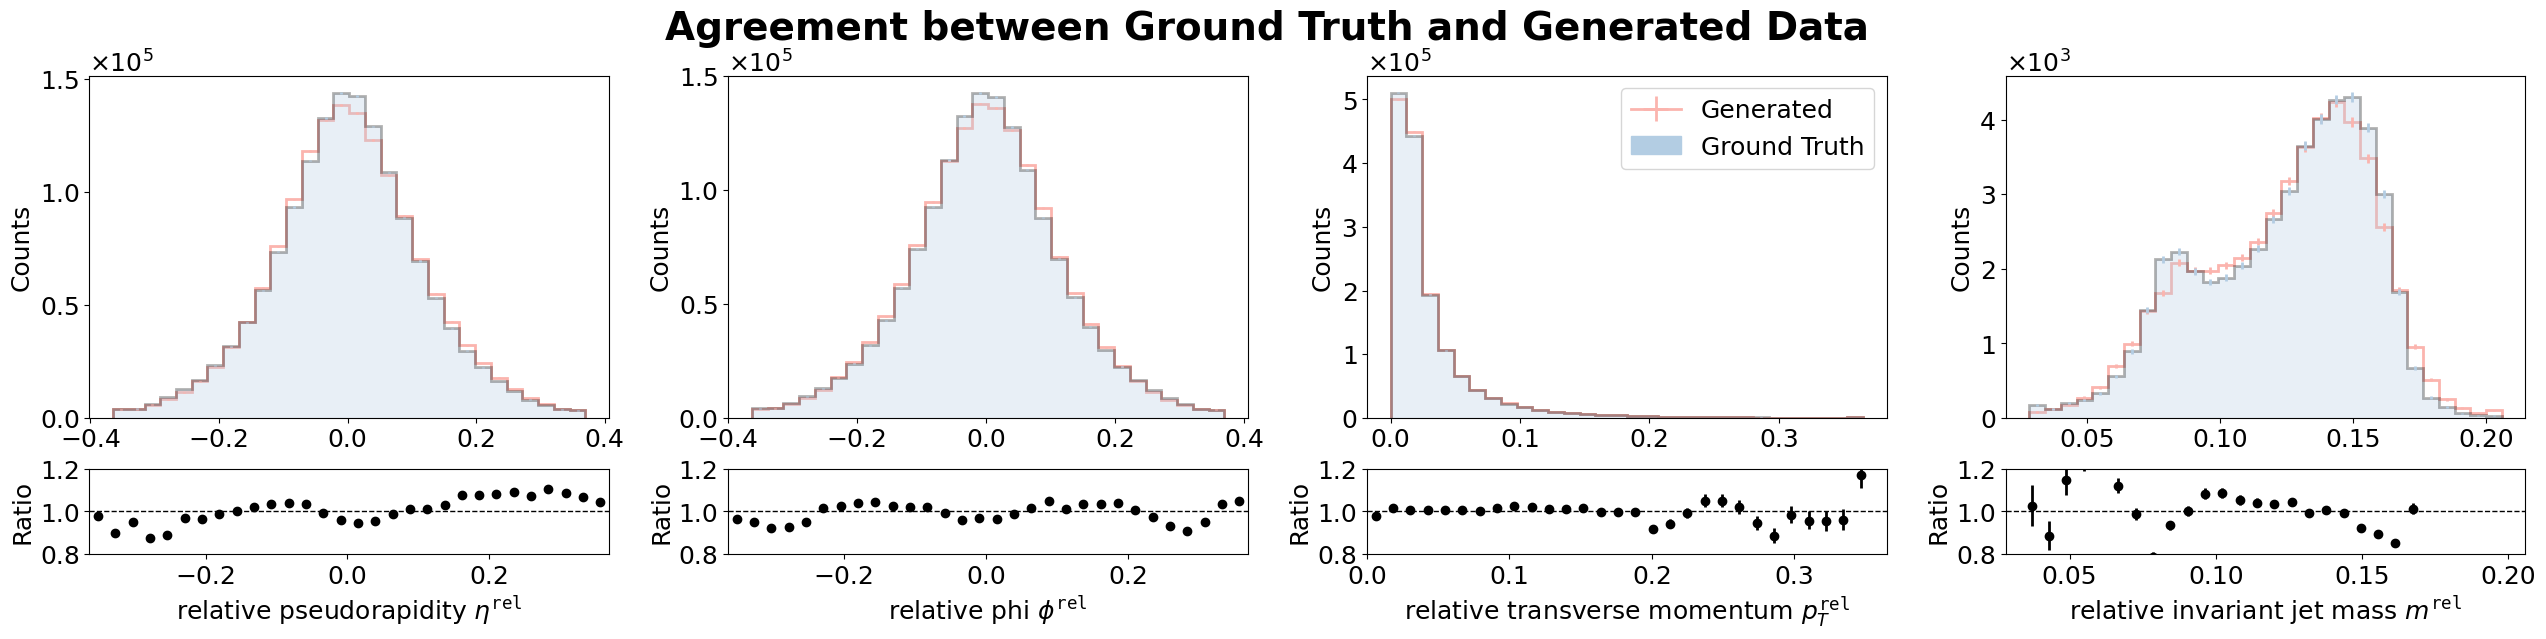

/tmp/ipykernel_229412/3716071407.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


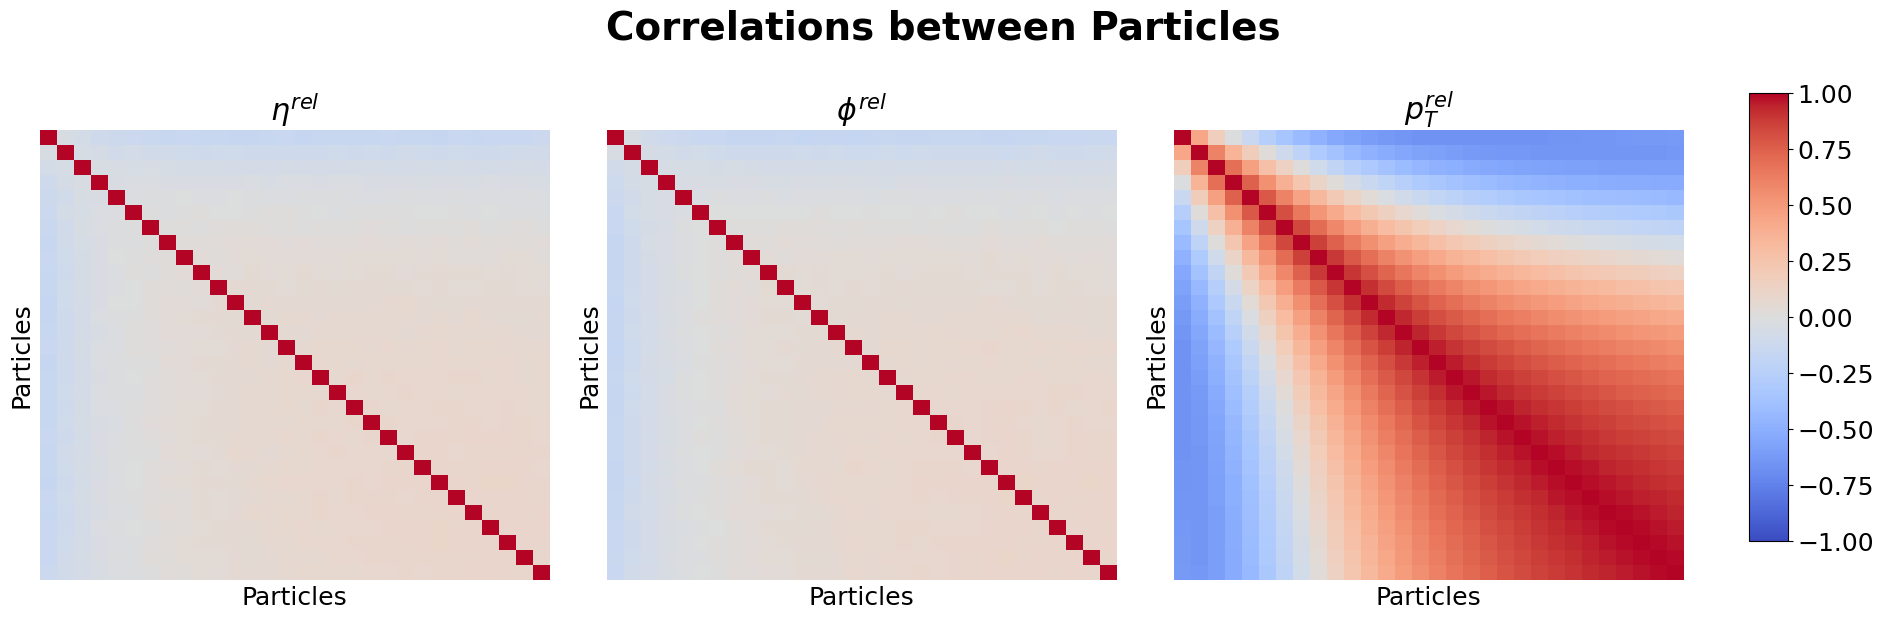

/tmp/ipykernel_229412/3716071407.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


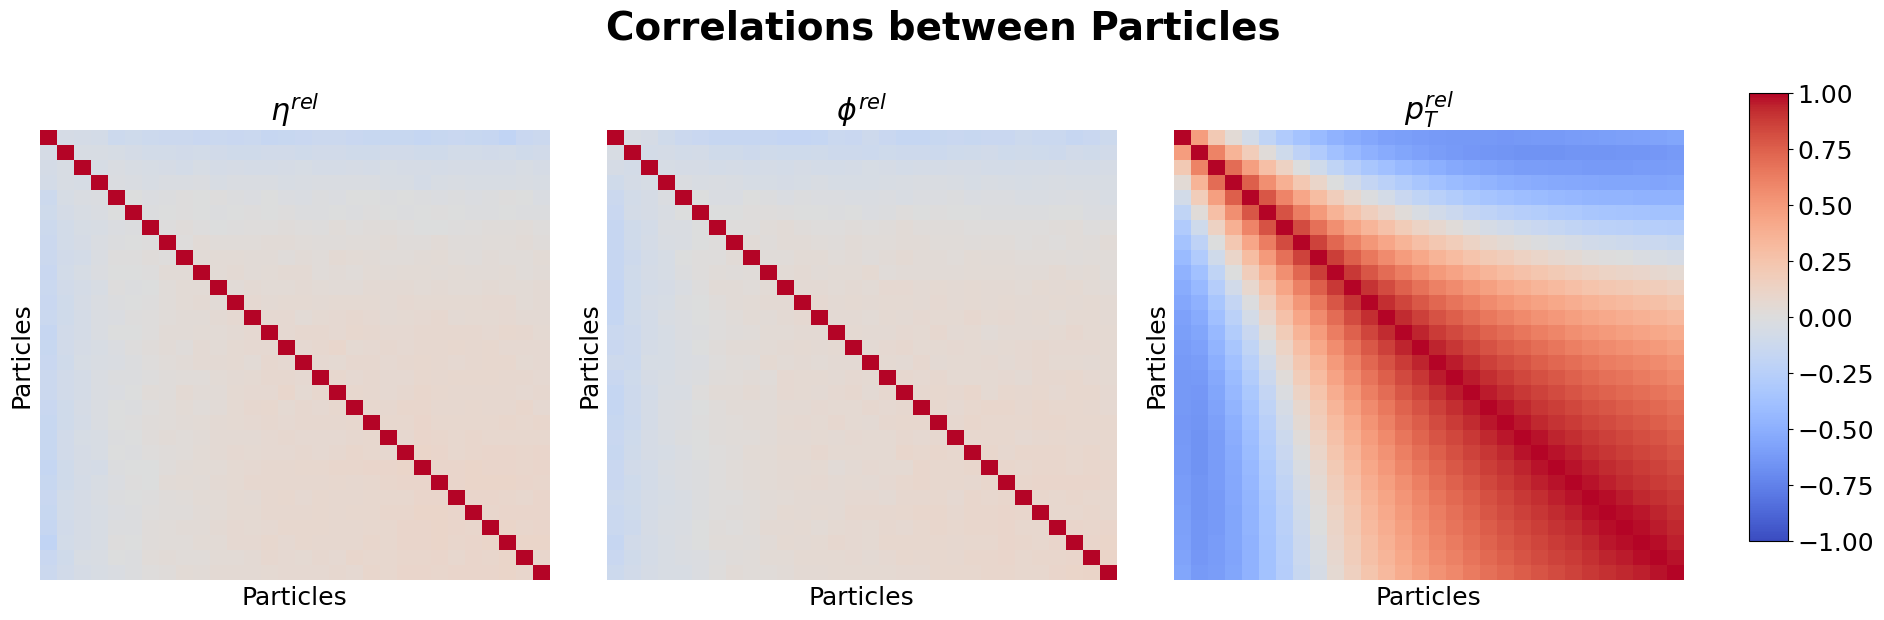

/tmp/ipykernel_229412/3716071407.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


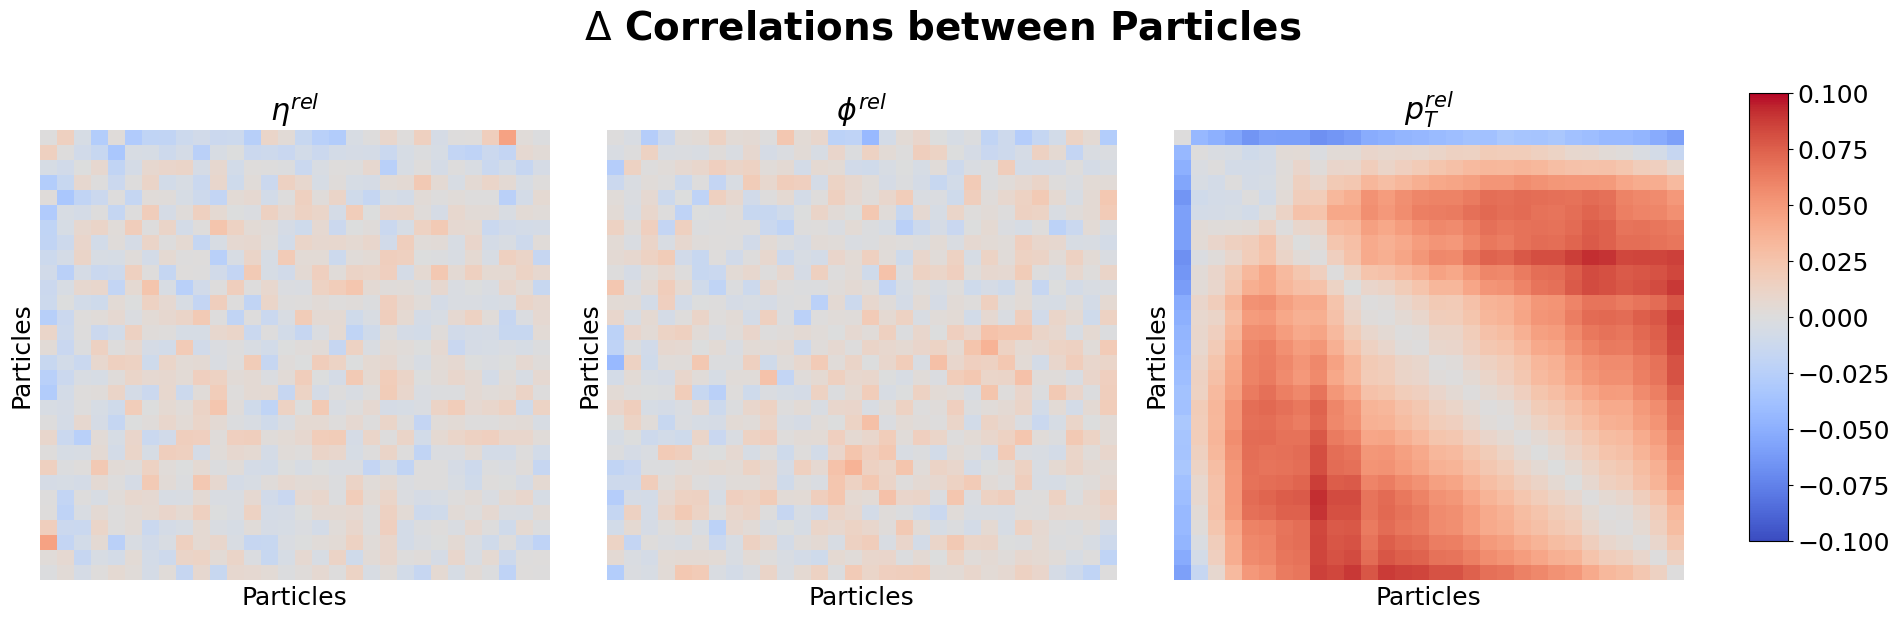

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
class plotting_point_cloud():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,step=None,logger=None,weight=1):

        self.step=step
        self.weight=weight
        self.fig_size1=[6.4, 6.4]
        self.fig_size2=[2*6.4, 6.4]
        self.fig_size3=[3*6.4, 6.4]
        self.fig_size4=[4*6.4, 6.4]
        self.alpha=0.3
        mpl.rcParams['lines.linewidth'] = 2
        font = { "size": 18}#"family": "normal",
        mpl.rc("font", **font)
        mpl.rc('lines', linewidth=2)
        sns.set_palette("Pastel1")
        if logger is not None:
            self.summary=logger
        else:
            self.summary = None
    def plot_ratio(self,h_real,h_fake,weighted,leg=-1,model_name=""):
        i = 0
        k = 0
        fig, ax = plt.subplots(2, 4, gridspec_kw={"height_ratios": [4, 1]}, figsize=self.fig_size4)
        # plt.suptitle("All Particles", fontsize=18)
        for v, name in zip(["eta", "phi", "pt", "m"], [r"relative pseudorapidity $\eta^{\tt rel}$", r"relative phi $\phi^{\tt rel}$", r"relative transverse momentum $p_T^{\tt rel}$", r"relative invariant jet mass $m^{\tt rel}$"]):
            main_ax_artists, sublot_ax_arists = h_fake[k].plot_ratio(
            h_real[k],
            ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
            rp_ylabel=r"Ratio",
            bar_="blue",
            rp_num_label="Generated",
            rp_denom_label="Ground Truth",
            rp_uncert_draw_type="line",  # line or bar)
            )
            i += 1
            ax[0, k].set_xlabel("")
            ax[0, k].patches[1].set_fill(True)
            ax[0, k].ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
            ax[0, k].patches[1].set_fc(sns.color_palette()[1])
            ax[0, k].patches[1].set_edgecolor("black")
            ax[0, k].patches[1].set_linewidth(2)
            ax[0, k].patches[1].set_alpha(self.alpha)
            ax[1, k].set_xlabel(name)
            ax[0, k].set_ylabel("Counts")
            ax[1, k].set_ylabel("Ratio")
            ax[0, k].patches[0].set_lw(2)
            ax[0, k].get_legend().remove()
            ax[1,k].set_ylim(0.8,1.2)
            k += 1
            
            
        ax[0, leg].legend(loc="best", fontsize=18)
        handles, labels = ax[0, leg].get_legend_handles_labels()
        ax[0, -1].locator_params(nbins=4, axis="x")
        ax[1, -1].locator_params(nbins=4, axis="x")
        handles[1] = mpatches.Patch(color=sns.color_palette()[1], label="The red data")
        ax[0, leg].legend(handles, labels)
        plt.suptitle("Agreement between Ground Truth and Generated Data", fontsize=28, fontweight="bold")
        plt.tight_layout(pad=0.3)
        
        # if not save==None:
        plt.savefig("plots/{}_jetnet.pdf".format(model_name),format="pdf")
        plt.show()
        plt.close()

    def plot_corr(self,real,fake,model,leg=-1):
        # Sample data: batch_size of 100, 30 particles, 3 features each

        
        def compute_correlation_matrix(tensor):
     # Sum over the angular and radial layers

            
            # Compute the correlation matrix across the batch dimension
            correlation_matrix = np.corrcoef(tensor, rowvar=False)
            
            return correlation_matrix
        diffs=[]
        for name,data in zip(["Ground Truth","Generated"],[true,fake]):
            # Compute correlation for each batch and then average
            correlations = []
            sorted_data, indices = torch.sort(data[:,:,2], dim=1, descending=True)

            # Use the indices to reorder the data
            data = torch.gather(data, 1, indices.unsqueeze(-1).expand(-1, -1, 3)).numpy()
            for feature_idx in range(3):
                correlation_matrix = compute_correlation_matrix(data[:, :, feature_idx])

                correlations.append(correlation_matrix)
                diffs.append(correlation_matrix)
            # Convert tensors to numpy arrays for plotting
            # Plot heatmaps
            fig, axes = plt.subplots(1, 3, figsize=self.fig_size3)
            fig.suptitle("Correlations between Particles", fontsize=28, fontweight="bold")
            sns.heatmap(correlations[0], ax=axes[0], cmap='coolwarm', cbar=False,vmin=-1,vmax=1)
            axes[0].set_title(r'$\eta^{rel}$')
            
            sns.heatmap(correlations[1], ax=axes[1], cmap='coolwarm', cbar=False,vmin=-1,vmax=1)
            axes[1].set_title(r'$\phi^{rel}$')

            cax3=sns.heatmap(correlations[2], ax=axes[2], cmap='coolwarm',cbar=False,vmin=-1,vmax=1
                             )
            axes[2].set_title(r'$p_T^{rel}$')
            for ax in axes:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlabel("Particles")
                ax.set_ylabel("Particles")
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(cax3.collections[0], cax=cbar_ax)  
            plt.tight_layout(rect=[0, 0, 0.9, 1])

            plt.savefig("plots/diff_"+model+".pdf",format="pdf")
            plt.show()
        diff=[diffs[0]-diffs[3],diffs[1]-diffs[4],diffs[2]-diffs[5]]

        fig, axes = plt.subplots(1, 3, figsize=self.fig_size3)
        fig.suptitle(r"$\Delta$ Correlations between Particles", fontsize=28, fontweight="bold")
        sns.heatmap(diff[0], ax=axes[0], cmap='coolwarm', cbar=False,vmin=-.1,vmax=.1)
        axes[0].set_title(r'$\eta^{rel}$')
        
        sns.heatmap(diff[1], ax=axes[1], cmap='coolwarm', cbar=False,vmin=-.1,vmax=.1)
        axes[1].set_title(r'$\phi^{rel}$')

        cax3=sns.heatmap(diff[2], ax=axes[2], cmap='coolwarm',cbar=False,vmin=-.1,vmax=.1)
        axes[2].set_title(r'$p_T^{rel}$')
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("Particles")
            ax.set_ylabel("Particles")
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(cax3.collections[0], cax=cbar_ax)  
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.savefig("plots/"+model+name+".pdf",format="pdf")
        plt.show()

from utils.helpers import get_hists,mass
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.patches as mpatches
fake=torch.cat(model.fake)
true=torch.cat(model.batch)
m_f,m_t=mass(fake),mass(true)
mins=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.001,dim=0)
maxs=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.999,dim=0)
fake=torch.clamp(fake,min=mins,max=maxs)
true=torch.clamp(true,min=mins,max=maxs)
mins=torch.cat((mins,torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0).unsqueeze(0)))
maxs=torch.cat((maxs,torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0).unsqueeze(0)))*1.01
m_f=torch.clamp(m_f,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
m_t=torch.clamp(m_t,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
hists=get_hists([30,30,30,30],mins,maxs,calo=model.name=="calo")
masks=torch.cat(model.masks) 

for var in range(3):
    hists["hists_real"][var].fill(true.reshape(-1,3)[(true.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
    hists["hists_fake"][var].fill(fake.reshape(-1,3)[(fake.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
hists["hists_real"][3].fill(m_t.cpu().numpy())
hists["hists_fake"][3].fill(m_f.cpu().numpy())

plot=plotting_point_cloud()
plot.plot_ratio(hists["hists_real"],hists["hists_fake"],weighted=False,leg=2,model_name=model_name)
plot.plot_corr(true,fake,model_name,leg=-1)
